<a href="https://colab.research.google.com/github/timosachsenberg/pyopenms-idfreeqc/blob/main/hackathon_ID_free_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install pyOpenMS if not already installed
!pip install pyopenms
!pip install pymzqc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.6 MB/s eta 0:00:00
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18129 sha256=bee31e4f6e16a16a412d4641f89467af0c68220f3ecdae811c3226319c949870
  Stored in directory: /root/.cache/pip/wheels/ce/81/f4/a2fb36db927b72a2171f2ac17bd1b29378bb993776c36785f1
Successfully built strict-rfc3339


In [ ]:
"""
ID-Free Mass Spectrometry Quality Control Metrics

This module implements PSI:MS compliant quality control metrics for mass spectrometry
data. Some metrics were translated from the R MsQuality Spectra metrics package.
It processes mzML files using pyOpenMS to compute ID-free QC metrics and generate mzQC JSON output.

Reference Implementation: MsQuality R package
    https://github.com/tnaake/MsQuality

PSI:MS Ontology:
    https://github.com/HUPO-PSI/psi-ms-CV

"""

from urllib.request import urlretrieve
import numpy as np
import json
from datetime import datetime
import pyopenms as oms
from mzqc import MZQCFile as qc
from typing import List, Tuple, Dict, Any, Optional, Union

# -------------------------------------------------------------------------
# Demo data (replace with your own mzML files)
# -------------------------------------------------------------------------
# Dictionary mapping URLs to local filenames for example mzML files
# You can replace these with your own URLs or local file paths
MZML_FILES = {
    "https://raw.githubusercontent.com/OpenMS/OpenMS/refs/heads/develop/share/OpenMS/examples/BSA/BSA1.mzML": "BSA1.mzML",
    "https://raw.githubusercontent.com/OpenMS/OpenMS/refs/heads/develop/share/OpenMS/examples/BSA/BSA2.mzML": "BSA2.mzML",
    "https://raw.githubusercontent.com/OpenMS/OpenMS/refs/heads/develop/share/OpenMS/examples/BSA/BSA3.mzML": "BSA3.mzML",
}

# Download all mzML files
print("Downloading mzML files...")
for url, filename in MZML_FILES.items():
    print(f"  Downloading {filename}...")
    urlretrieve(url, filename)
print("Download complete.\n")

# -------------------------------------------------------------------------
# PSI:MS / mzQC metric accessions we could confirm
# -------------------------------------------------------------------------
METRIC_ACCESSIONS = {
    # chromatographyDuration
    "ChromatographyDuration": "MS:4000053",

    # rtOverMsQuarters (MS1 / MS2) - using non-obsolete accessions
    "RT_MS1_Quarter1": "MS:4000184",
    "RT_MS1_Quarter2": "MS:4000184",
    "RT_MS1_Quarter3": "MS:4000184",
    "RT_MS1_Quarter4": "MS:4000184",
    "RT_MS2_Quarter1": "MS:4000185",
    "RT_MS2_Quarter2": "MS:4000185",
    "RT_MS2_Quarter3": "MS:4000185",
    "RT_MS2_Quarter4": "MS:4000185",

    # ticQuartileToQuartileLogRatio (MS1) - using non-obsolete accessions
    "MS1_TICchange_LogRatio_Q2overQ1": "MS:4000186",
    "MS1_TICchange_LogRatio_Q3overQ2": "MS:4000186",
    "MS1_TICchange_LogRatio_Q4overQ3": "MS:4000186",
    "MS1_TIC_LogRatio_Q2overQ1": "MS:4000187",
    "MS1_TIC_LogRatio_Q3overQ2": "MS:4000187",
    "MS1_TIC_LogRatio_Q4overQ3": "MS:4000187",

    # numberSpectra
    "MS1_NumberOfSpectra": "MS:4000059",
    "MS2_NumberOfSpectra": "MS:4000060",

    # empty scans
    "EmptyScans_MS1": "MS:4000099",
    "EmptyScans_MS2": "MS:4000100",

    # TIC quantile RT fractions
    "TICQuantileRTFraction_0%":   "MS:4000183",
    "TICQuantileRTFraction_25%":  "MS:4000183",
    "TICQuantileRTFraction_50%":  "MS:4000183",
    "TICQuantileRTFraction_75%":  "MS:4000183",
    "TICQuantileRTFraction_100%": "MS:4000183",

    # mean / median charge
    "ChargeMean": "MS:4000173",
    "ChargeMedian": "MS:4000175",

    # Area under TIC
    "AreaUnderTIC_MS1": "MS:4000029",
    "AreaUnderTIC_MS2": "MS:4000030",

    # Signal jumps/falls
    "MS1_SignalJump10x_Count": "MS:4000097",
    "MS1_SignalFall10x_Count": "MS:4000098",

    # MS run duration
    "MS_Run_Duration": "MS:4000067",

    # Number of chromatograms
    "TotalChromatograms": "MS:4000071",

    # Polarity (using scan polarity terms)
    "Polarity_MS1_positive": "MS:1000130",
    "Polarity_MS1_negative": "MS:1000129",
    "Polarity_MS2_positive": "MS:1000130",
    "Polarity_MS2_negative": "MS:1000129",

    # FAIMS compensation voltage
    "FAIMS_CV_Min": "MS:1001581",
    "FAIMS_CV_Max": "MS:1001581",
}

# -------------------------------------------------------------------------
# Metric descriptions from PSI:MS ontology
# -------------------------------------------------------------------------
METRIC_DESCRIPTIONS = {
    # Chromatography duration
    "ChromatographyDuration": "The retention time duration of the chromatography in seconds.",

    # RT over MS quarters
    "RT_MS1_Quarter1": "The interval when the first quarter of all MS1 events was acquired, divided by RT duration.",
    "RT_MS1_Quarter2": "The interval when the second quarter of all MS1 events was acquired, divided by RT duration.",
    "RT_MS1_Quarter3": "The interval when the third quarter of all MS1 events was acquired, divided by RT duration.",
    "RT_MS1_Quarter4": "The interval when the fourth quarter of all MS1 events was acquired, divided by RT duration.",
    "RT_MS2_Quarter1": "The interval when the first quarter of all MS2 events was acquired, divided by RT duration.",
    "RT_MS2_Quarter2": "The interval when the second quarter of all MS2 events was acquired, divided by RT duration.",
    "RT_MS2_Quarter3": "The interval when the third quarter of all MS2 events was acquired, divided by RT duration.",
    "RT_MS2_Quarter4": "The interval when the fourth quarter of all MS2 events was acquired, divided by RT duration.",

    # TIC quartile ratios
    "MS1_TICchange_LogRatio_Q2overQ1": "Log ratio of MS1 TIC-change Q2 to Q1. TIC changes are differences between successive MS1 TIC values.",
    "MS1_TICchange_LogRatio_Q3overQ2": "Log ratio of MS1 TIC-change Q3 to Q2. TIC changes are differences between successive MS1 TIC values.",
    "MS1_TICchange_LogRatio_Q4overQ3": "Log ratio of MS1 TIC-change Q4 to Q3. TIC changes are differences between successive MS1 TIC values.",
    "MS1_TIC_LogRatio_Q2overQ1": "Log ratio of MS1 TIC Q2 to Q1.",
    "MS1_TIC_LogRatio_Q3overQ2": "Log ratio of MS1 TIC Q3 to Q2.",
    "MS1_TIC_LogRatio_Q4overQ3": "Log ratio of MS1 TIC Q4 to Q3.",

    # Number of spectra
    "MS1_NumberOfSpectra": "The number of MS1 events in the run.",
    "MS2_NumberOfSpectra": "The number of MS2 events in the run.",

    # Empty scans
    "EmptyScans_MS1": "Number of MS1 scans where the peaks' intensity sums to 0 (i.e. no peaks or only 0-intensity peaks).",
    "EmptyScans_MS2": "Number of MS2 scans where the peaks' intensity sums to 0 (i.e. no peaks or only 0-intensity peaks).",

    # TIC quantile RT fractions
    "TICQuantileRTFraction_0%": "The relative RT when the cumulative TIC first exceeds 0% of total TIC.",
    "TICQuantileRTFraction_25%": "The relative RT when the cumulative TIC first exceeds 25% of total TIC.",
    "TICQuantileRTFraction_50%": "The relative RT when the cumulative TIC first exceeds 50% of total TIC.",
    "TICQuantileRTFraction_75%": "The relative RT when the cumulative TIC first exceeds 75% of total TIC.",
    "TICQuantileRTFraction_100%": "The relative RT when the cumulative TIC first exceeds 100% of total TIC.",

    # Charge metrics
    "ChargeMean": "Mean MS2 precursor charge in all spectra.",
    "ChargeMedian": "Median MS2 precursor charge in all spectra.",
    "ChargeMin": "Minimum MS2 precursor charge state observed.",
    "ChargeMax": "Maximum MS2 precursor charge state observed.",
    "ChargeRatio_3over2": "The ratio of 3+ over 2+ MS2 precursor charge count. Higher ratios may preferentially favor longer peptides.",
    "ChargeRatio_4over2": "The ratio of 4+ over 2+ MS2 precursor charge count.",

    # Custom metrics (non-PSI:MS)
    "TIC_CV_MS1": "Coefficient of variation of MS1 total ion current. Indicates stability of MS1 signal.",
    "TIC_CV_MS2": "Coefficient of variation of MS2 total ion current. Indicates stability of MS2 signal.",
    "BasePeakMean_MS1": "Mean of base peak intensities across all MS1 spectra.",
    "BasePeakMean_MS2": "Mean of base peak intensities across all MS2 spectra.",
    "ScanRate_MS1": "MS1 scan rate (scans per minute).",
    "ScanRate_MS2": "MS2 scan rate (scans per minute).",
    "MS1_to_MS2_Ratio": "Ratio of MS1 to MS2 spectra counts.",

    # m/z and RT ranges
    "MS2_mzRange_min": "Lower limit of m/z precursor values at which MS2 spectra are recorded.",
    "MS2_mzRange_max": "Upper limit of m/z precursor values at which MS2 spectra are recorded.",
    "MS1_rtRange_min": "Lower limit of retention time at which MS1 spectra are recorded (seconds).",
    "MS1_rtRange_max": "Upper limit of retention time at which MS1 spectra are recorded (seconds).",

    # Signal jumps/falls
    "MS1_SignalJump10x_Count": "Number of times MS1 TIC increased more than 10-fold between adjacent scans. High counts may indicate ESI stability issues.",
    "MS1_SignalFall10x_Count": "Number of times MS1 TIC decreased more than 10-fold between adjacent scans. High counts may indicate ESI stability issues.",

    # Precursor intensity stats
    "PrecursorIntensity_Q1": "25th percentile (Q1) of MS2 precursor intensities.",
    "PrecursorIntensity_Q2": "50th percentile (Q2/median) of MS2 precursor intensities.",
    "PrecursorIntensity_Q3": "75th percentile (Q3) of MS2 precursor intensities.",
    "PrecursorIntensity_Mean": "Mean of MS2 precursor intensities.",
    "PrecursorIntensity_Sd": "Standard deviation of MS2 precursor intensities.",

    # Median precursor m/z
    "MedianPrecursorMz_MS2": "Median m/z value for MS2 precursors.",

    # RT IQR metrics
    "RT_IQR_MS1": "Interquartile range of retention times for MS1 spectra (seconds). Longer times indicate better chromatographic separation.",
    "RT_IQR_Rate_MS1": "Rate of MS1 spectra per second in the RT interquartile range. Higher rates indicate efficient sampling.",

    # Area under TIC
    "AreaUnderTIC_MS1": "Sum of all MS1 TIC values (area under the total ion chromatogram).",
    "AreaUnderTIC_RTQ25_MS1": "Area under MS1 TIC for the first RT quartile (0-25%).",
    "AreaUnderTIC_RTQ50_MS1": "Area under MS1 TIC for the second RT quartile (25-50%).",
    "AreaUnderTIC_RTQ75_MS1": "Area under MS1 TIC for the third RT quartile (50-75%).",
    "AreaUnderTIC_RTQ100_MS1": "Area under MS1 TIC for the fourth RT quartile (75-100%).",

    # Extent of precursor intensity
    "ExtentPrecursorIntensity_95over5_MS2": "Ratio of 95th to 5th percentile of MS2 precursor intensity. Approximates dynamic range of signal.",

    # Median TIC in RT ranges
    "MedianTIC_in_RT_IQR_MS1": "Median MS1 TIC in the RT range between Q1 and Q3 of retention times.",
    "MedianTIC_in_ShortestHalfRT_MS1": "Median MS1 TIC in the shortest RT range containing half of all spectra.",

    # MS levels
    "NumberOfMSLevels": "The number of distinct MS levels present in the run (e.g., MS1, MS2, MS3).",

    # Polarity statistics
    "Polarity_MS1_positive": "Number of MS1 spectra acquired in positive polarity mode.",
    "Polarity_MS1_negative": "Number of MS1 spectra acquired in negative polarity mode.",
    "Polarity_MS1_unknown": "Number of MS1 spectra with unknown polarity.",
    "Polarity_MS2_positive": "Number of MS2 spectra acquired in positive polarity mode.",
    "Polarity_MS2_negative": "Number of MS2 spectra acquired in negative polarity mode.",
    "Polarity_MS2_unknown": "Number of MS2 spectra with unknown polarity.",

    # MS1 cycle time
    "AvgMS1CycleTime": "Average time between consecutive MS1 scans (seconds). Indicates acquisition duty cycle and sampling rate.",

    # Chromatogram statistics
    "TotalChromatograms": "Total number of chromatograms in the mzML file.",
    "Chromatograms_TIC": "Number of Total Ion Current (TIC) chromatograms.",
    "Chromatograms_BPC": "Number of Base Peak Chromatograms (BPC).",
    "Chromatograms_SRM": "Number of Selected Reaction Monitoring (SRM) chromatograms.",
    "Chromatograms_MRM": "Number of Multiple Reaction Monitoring (MRM) chromatograms.",
    "Chromatograms_XIC": "Number of Extracted Ion Chromatograms (XIC).",
    "Chromatograms_SIM": "Number of Selected Ion Monitoring (SIM) chromatograms.",
    "Chromatograms_Unknown": "Number of chromatograms with unknown type.",
    "Chromatograms_RT_min": "Minimum retention time covered by chromatograms (seconds).",
    "Chromatograms_RT_max": "Maximum retention time covered by chromatograms (seconds).",

    # Peak type statistics
    "MS1_PeakType_Annotated": "Peak type from metadata for MS1 (centroid, profile, or unknown).",
    "MS1_PeakType_Estimated": "Peak type estimated from peak spacing for MS1 (centroid, profile, or unknown).",
    "MS2_PeakType_Annotated": "Peak type from metadata for MS2 (centroid, profile, or unknown).",
    "MS2_PeakType_Estimated": "Peak type estimated from peak spacing for MS2 (centroid, profile, or unknown).",

    # Mass analyzer information
    "MassAnalyzer_0_Type": "Type of the first mass analyzer (e.g., FTICR, Orbitrap, TOF, IT, Q).",
    "MassAnalyzer_0_Resolution": "Resolution of the first mass analyzer.",
    "MassAnalyzer_1_Type": "Type of the second mass analyzer (if present).",
    "MassAnalyzer_1_Resolution": "Resolution of the second mass analyzer (if present).",

    # Total peaks
    "TotalSpectralPeaks": "Total number of peaks across all spectra in the run.",
    "TotalChromatographicPeaks": "Total number of peaks across all chromatograms.",

    # FAIMS
    "FAIMS_CV_Count": "Number of different FAIMS compensation voltages used.",
    "FAIMS_CV_Min": "Minimum FAIMS compensation voltage (V).",
    "FAIMS_CV_Max": "Maximum FAIMS compensation voltage (V).",
}

# -------------------------------------------------------------------------
# Utilities
# -------------------------------------------------------------------------
def _filter_by_mslevel(exp: oms.MSExperiment, level: int) -> List[oms.MSSpectrum]:
    """
    Filter MSExperiment spectra by MS level.

    Args:
        exp: MSExperiment object
        level: int, MS level to filter (1, 2, 3, etc.)

    Returns:
        list: Spectra matching the specified MS level
    """
    return [s for s in exp if s.getMSLevel() == level]

def _rts(specs: List[oms.MSSpectrum]) -> np.ndarray:
    """
    Extract retention times from spectra.

    Args:
        specs: list of MSSpectrum objects

    Returns:
        np.ndarray: Array of retention times in seconds
    """
    return np.array([s.getRT() for s in specs], dtype=float) if specs else np.array([], dtype=float)

def _ion_counts(specs: List[oms.MSSpectrum]) -> np.ndarray:
    """
    Calculate total ion count (TIC) for each spectrum.

    Equivalent to R's ionCount() function.

    Args:
        specs: list of MSSpectrum objects

    Returns:
        np.ndarray: Array of TIC values (sum of intensities per spectrum)
    """
    return np.array([s.calculateTIC() for s in specs], dtype=float)

def _is_empty_spectrum(sp: oms.MSSpectrum) -> bool:
    """
    Check if a spectrum is empty or has zero total intensity.

    A spectrum is considered empty if it has no peaks or all peak intensities sum to 0.

    Args:
        sp: MSSpectrum object

    Returns:
        bool: True if spectrum is empty
    """
    if sp.size() == 0:
        return True
    return sp.calculateTIC() == 0.0

def _precursor_values(specs: List[oms.MSSpectrum]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract precursor m/z, intensity, and charge from MS2/MSn spectra.

    Args:
        specs: list of MSSpectrum objects

    Returns:
        tuple: (mzs, intensities, charges) as numpy arrays
               NaN values indicate missing precursor information
    """
    mzs, intens, charges = [], [], []
    for sp in specs:
        precs = sp.getPrecursors()
        if not precs:
            mzs.append(np.nan); intens.append(np.nan); charges.append(np.nan)
            continue
        p = precs[0]
        mzs.append(float(p.getMZ()) if p.getMZ() else np.nan)
        intens.append(float(p.getIntensity()) if p.getIntensity() else np.nan)
        charges.append(int(p.getCharge()) if p.getCharge() else np.nan)
    return np.array(mzs, dtype=float), np.array(intens, dtype=float), np.array(charges, dtype=float)

def _iqr(arr: Union[np.ndarray, List[float]]) -> float:
    """
    Calculate interquartile range (Q3 - Q1).

    NaN values are removed before calculation.

    Args:
        arr: array-like numeric data

    Returns:
        float: IQR value, or NaN if insufficient data
    """
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0: return np.nan
    q75, q25 = np.percentile(arr, [75, 25])
    return float(q75 - q25)

def _nanmedian(arr: Union[np.ndarray, List[float]]) -> float:
    """
    Calculate median with NaN removal.

    Args:
        arr: array-like numeric data

    Returns:
        float: Median value, or NaN if no valid data
    """
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    return float(np.median(arr)) if arr.size else np.nan

# -------------------------------------------------------------------------
# Helper functions for polarity and chromatogram analysis
# -------------------------------------------------------------------------
def _polarity_to_str(pol: Any) -> str:
    """
    Convert InstrumentSettings.Polarity enum to string.

    Args:
        pol: Polarity enum value

    Returns:
        str: "positive", "negative", or "unknown"
    """
    try:
        if pol == oms.InstrumentSettings.POLNULL:
            return "unknown"
        elif pol == oms.InstrumentSettings.POSITIVE:
            return "positive"
        elif pol == oms.InstrumentSettings.NEGATIVE:
            return "negative"
    except Exception:
        pass
    return "unknown"

def _extract_spectrum_polarity(spec: oms.MSSpectrum) -> str:
    """
    Extract polarity from a spectrum.

    Args:
        spec: MSSpectrum object

    Returns:
        str: "positive", "negative", or "unknown"
    """
    try:
        pol = spec.getInstrumentSettings().getPolarity()
        return _polarity_to_str(pol)
    except Exception:
        return "unknown"

# -------------------------------------------------------------------------
# MsQuality Spectra metrics (translated)
# -------------------------------------------------------------------------
def chromatography_duration(exp: oms.MSExperiment) -> float:
    """
    Chromatography duration (MS:4000053).

    "The retention time duration of the chromatography in seconds." [PSI:MS]

    The metric is calculated as follows:
    (1) The retention time associated to all spectra is obtained,
    (2) The maximum and minimum retention time is obtained,
    (3) The difference between maximum and minimum is calculated and returned.

    Retention time values that are NA are removed.

    Details:
        MS:4000053
        synonym: "RT-Duration" RELATED [PMID:24494671]
        is_a: MS:4000003 ! single value
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000012 ! single run based metric
        relationship: has_metric_category MS:4000016 ! retention time metric
        relationship: has_value_type xsd:float
        relationship: has_value_concept NCIT:C25330 ! Duration
        relationship: has_units UO:0000010 ! second

    Args:
        exp: MSExperiment object

    Returns:
        float: Chromatography duration in seconds

    Example:
        >>> duration = chromatography_duration(exp)
    """
    rts_all = _rts(list(exp))
    return float(np.max(rts_all) - np.min(rts_all)) if rts_all.size else np.nan

def rt_over_ms_quarters(exp: oms.MSExperiment, ms_level: int = 1) -> List[float]:
    """
    MS1 quarter RT fraction (MS:4000055) or MS2 quarter RT fraction (MS:4000056).

    MS:4000055:
    "The interval used for acquisition of the first, second, third, and fourth
    quarter of all MS1 events divided by retention time duration." [PSI:MS]

    MS:4000056:
    "The interval used for acquisition of the first, second, third, and fourth
    quarter of all MS2 events divided by retention time duration." [PSI:MS]

    The metric is calculated as follows:
    (1) The retention time duration of the whole experiment is determined
        (taking into account all MS levels),
    (2) The spectra are filtered according to the MS level and subsequently
        ordered according to retention time,
    (3) The MS events are split into four (approximately) equal parts,
    (4) The relative retention time is calculated (using the retention time
        duration from (1) and taking into account the minimum retention time),
    (5) The relative retention time values associated to the MS event parts
        are returned.

    Details:
        MS:4000055
        synonym: "RT-MS-Q1" RELATED [PMID:24494671]
        is_a: MS:4000004 ! n-tuple
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000016 ! retention time metric
        relationship: has_metric_category MS:4000021 ! MS1 metric

        MS:4000056
        synonym: "RT-MSMS-Q1" RELATED [PMID:24494671]
        relationship: has_metric_category MS:4000022 ! MS2 metric

    Note:
        chromatographyDuration considers the total runtime (including MS1 and MS2 scans).
        Returns [NaN, NaN, NaN, NaN] if filtered spectra has less than 4 scan events.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        list: Four float values representing RT fractions for each quarter

    Example:
        >>> quarters_ms1 = rt_over_ms_quarters(exp, ms_level=1)
        >>> quarters_ms2 = rt_over_ms_quarters(exp, ms_level=2)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    if len(specs) < 4:
        return [np.nan]*4
    specs = sorted(specs, key=lambda s: s.getRT())
    rts = _rts(specs)
    total = chromatography_duration(exp)
    if not np.isfinite(total) or total == 0:
        return [np.nan]*4
    rtmin = float(np.min(rts))
    # Equal quartile slices by index; fallback to quantile positions if needed
    ind = np.repeat(np.arange(1,5), repeats=int(np.ceil(len(specs)/4)))[:len(specs)]
    edges = np.where(np.diff(ind, prepend=ind[0]) != 0)[0] - 1
    edges = (edges[1:].tolist() + [len(specs)-1]) if len(specs) >= 4 else [len(specs)-1]
    if len(edges) != 4:
        qpos = (np.array([0.25, 0.50, 0.75, 1.00]) * (len(specs)-1)).round().astype(int)
        edges = qpos.tolist()
    rel = (rts[edges] - rtmin) / total
    return [float(x) for x in rel]

def tic_quartile_to_quartile_log_ratio(exp: oms.MSExperiment, ms_level: int = 1, mode: str = "TIC", relative_to: str = "previous") -> List[float]:
    """
    MS1 TIC-change quartile ratios (MS:4000057) or MS1 TIC quartile ratios (MS:4000058).

    MS:4000057:
    "The log ratios of successive TIC-change quartiles. The TIC changes are
    the list of MS1 total ion current (TIC) value changes from one to the next
    scan, produced when each MS1 TIC is subtracted from the preceding MS1 TIC.
    The metric's value triplet represents the log ratio of the TIC-change
    Q2 to Q1, Q3 to Q2, TIC-change-max to Q3" [PSI:MS]
    For calculation of MS:4000057 set mode = "TIC_change".

    MS:4000058:
    "The log ratios of successive TIC quartiles. The metric's value triplet
    represents the log ratios of TIC-Q2 to TIC-Q1, TIC-Q3 to TIC-Q2,
    TIC-max to TIC-Q3." [PSI:MS]
    For calculation of MS:4000058 set mode = "TIC".

    The metric is calculated as follows:
    (1) The TIC (ionCount) of the Spectra is calculated per scan event
        (with spectra ordered by retention time),
    (2) For MS:4000057, differences between TIC values are calculated between
        subsequent scan events; for MS:4000058, TIC values are taken as-is,
    (3) For both metrics, the ratios between 25%, 50%, 75%, and 100% quantile
        to the 25% quantile (or successive quartiles) are calculated,
    (4) The log values of the ratios are returned.

    Note:
        This function interprets the quantiles from [PSI:MS] definition as
        quartiles, i.e. the 0, 25, 50, 75 and 100% quantiles are used.

    Details:
        MS:4000057
        synonym: "MS1-TIC-Change-Q2" RELATED [PMID:24494671]
        is_a: MS:4000004 ! n-tuple
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000017 ! chromatogram metric
        relationship: has_value_concept STATO:0000105 ! log signal intensity ratio

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)
        mode: str, either "TIC_change" or "TIC"
        relative_to: str, either "previous" or "Q1"

    Returns:
        list: Three float values representing log ratios [Q2/Q1, Q3/Q2, Q4/Q3]
              or [Q2/Q1, Q3/Q1, Q4/Q1] depending on relative_to parameter

    Example:
        >>> ratios_change = tic_quartile_to_quartile_log_ratio(exp, mode="TIC_change")
        >>> ratios_tic = tic_quartile_to_quartile_log_ratio(exp, mode="TIC")
    """
    specs = _filter_by_mslevel(exp, ms_level)
    if not specs: return [np.nan, np.nan, np.nan]
    specs = sorted(specs, key=lambda s: s.getRT())
    tic = _ion_counts(specs)
    if mode == "TIC_change":
        if tic.size < 2: return [np.nan, np.nan, np.nan]
        tic = np.diff(tic)
    qs = np.quantile(tic, [0, 0.25, 0.50, 0.75, 1.0])
    q1, q2, q3, q4 = qs[1], qs[2], qs[3], qs[4]
    with np.errstate(divide='ignore', invalid='ignore'):
        if relative_to == "Q1":
            ratios = np.array([q2/q1, q3/q1, q4/q1], dtype=float)
        else:
            ratios = np.array([q2/q1, q3/q2, q4/q3], dtype=float)
        logs = np.log(ratios)
    return [float(x) if np.isfinite(x) else np.nan for x in logs]

def number_spectra(exp: oms.MSExperiment, ms_level: int = 1) -> int:
    """
    Number of MS1 spectra (MS:4000059) or number of MS2 spectra (MS:4000060).

    MS:4000059:
    "The number of MS1 events in the run." [PSI:MS]

    MS:4000060:
    "The number of MS2 events in the run." [PSI:MS]

    For MS:4000059, ms_level is set to 1. For MS:4000060, ms_level is set to 2.

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The number of spectra are obtained (length) and returned.

    Details:
        MS:4000059
        synonym: "MS1-Count" EXACT [PMID:24494671]
        is_a: MS:4000003 ! single value
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_units UO:0000189 ! count unit

        MS:4000060
        synonym: "MS2-Count" EXACT [PMID:24494671]
        relationship: has_metric_category MS:4000022 ! MS2 metric

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to count (default: 1)

    Returns:
        int: Number of spectra at specified MS level

    Example:
        >>> n_ms1 = number_spectra(exp, ms_level=1)
        >>> n_ms2 = number_spectra(exp, ms_level=2)
    """
    return int(len(_filter_by_mslevel(exp, ms_level)))

def mz_acquisition_range(exp: oms.MSExperiment, ms_level: int = 2) -> Tuple[float, float]:
    """
    m/z acquisition range (MS:4000069).

    MS:4000069:
    "Upper and lower limit of m/z precursor values at which MSn spectra are
    recorded." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The precursor m/z values of the peaks within the spectra are obtained,
    (3) The minimum and maximum precursor m/z values are obtained and returned.

    Details:
        MS:4000069
        is_a: MS:4000004 ! n-tuple
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000019 ! MS metric
        relationship: has_units MS:1000040 ! m/z
        relationship: has_value_concept STATO:0000035 ! range

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 2)

    Returns:
        tuple: (min_mz, max_mz) as floats

    Example:
        >>> mz_min, mz_max = mz_acquisition_range(exp, ms_level=2)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    mzs, _, _ = _precursor_values(specs)
    mzs = mzs[~np.isnan(mzs)]
    if mzs.size == 0: return (np.nan, np.nan)
    return (float(np.min(mzs)), float(np.max(mzs)))

def rt_acquisition_range(exp: oms.MSExperiment, ms_level: int = 1) -> Tuple[float, float]:
    """
    Retention time acquisition range (MS:4000070).

    MS:4000070:
    "Upper and lower limit of retention time at which spectra are recorded."
    [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The retention time values of the features within the spectra are obtained,
    (3) The minimum and maximum retention time values are obtained and returned.

    Details:
        MS:4000070
        is_a: MS:4000004 ! n-tuple
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000016 ! retention time metric
        relationship: has_units UO:0000010 ! second
        relationship: has_value_concept STATO:0000035 ! range

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        tuple: (min_rt, max_rt) as floats in seconds

    Example:
        >>> rt_min, rt_max = rt_acquisition_range(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    rts = _rts(specs)
    if rts.size == 0: return (np.nan, np.nan)
    return (float(np.min(rts)), float(np.max(rts)))

def ms_signal_10x_change(exp: oms.MSExperiment, change: str = "jump", ms_level: int = 1) -> int:
    """
    MS1 signal jump (10x) count (MS:4000097) or MS1 signal fall (10x) count (MS:4000098).

    MS:4000097:
    "The number of times where MS1 TIC increased more than 10-fold between
    adjacent MS1 scans. An unusual high count of signal jumps or falls can
    indicate ESI stability issues." [PSI:MS]

    MS:4000098:
    "The number of times where MS1 TIC decreased more than 10-fold between
    adjacent MS1 scans. An unusual high count of signal jumps or falls can
    indicate ESI stability issues." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The spectra are ordered by retention time,
    (3) The intensity values of the features are obtained via ion count,
    (4) The signal jumps/declines of the intensity values with the two
        subsequent intensity values is calculated,
    (5) For MS:4000097, signal jumps by a factor of ten or more are counted;
        For MS:4000098, signal declines by a factor of ten or more are counted.

    Details:
        MS:4000097
        synonym: "IS-1A" RELATED []
        is_a: MS:4000003 ! single value
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000021 ! MS1 metric
        relationship: has_units UO:0000189 ! count unit

        MS:4000098
        synonym: "IS-1B" RELATED []

    Note:
        This function uses ionCount as an equivalent to the TIC.

    Args:
        exp: MSExperiment object
        change: str, either "jump" or "fall"
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        int: Count of 10x signal changes

    Example:
        >>> jumps = ms_signal_10x_change(exp, change="jump", ms_level=1)
        >>> falls = ms_signal_10x_change(exp, change="fall", ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    if len(specs) < 2: return np.nan
    specs = sorted(specs, key=lambda s: s.getRT())
    tic = _ion_counts(specs)
    prev, foll = tic[:-1], tic[1:]
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = foll / prev
    if change == "jump":
        return int(np.nansum(ratio >= 10.0))
    else:
        return int(np.nansum(ratio <= 0.1))

def number_empty_scans(exp: oms.MSExperiment, ms_level: int = 1) -> int:
    """
    Number of empty MS1 scans (MS:4000099), MS2 scans (MS:4000100), or MS3 scans (MS:4000101).

    MS:4000099:
    "Number of MS1 scans where the scans' peaks intensity sums to 0
    (i.e. no peaks or only 0-intensity peaks)." [PSI:MS]

    MS:4000100:
    "Number of MS2 scans where the scans' peaks intensity sums to 0
    (i.e. no peaks or only 0-intensity peaks)." [PSI:MS]

    MS:4000101:
    "Number of MS3 scans where the scans' peaks intensity sums to 0
    (i.e. no peaks or only 0-intensity peaks)." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The intensities per entry are obtained,
    (3) The number of intensity entries that are NULL, NA, or have a sum of 0
        are obtained and returned.

    Details:
        MS:4000099
        is_a: MS:4000003 ! single value
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000021 ! MS1 metric
        relationship: has_units UO:0000189 ! count unit

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        int: Count of empty scans

    Example:
        >>> empty_ms1 = number_empty_scans(exp, ms_level=1)
        >>> empty_ms2 = number_empty_scans(exp, ms_level=2)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    return int(np.sum([_is_empty_spectrum(s) for s in specs]))

def precursor_intensity_stats(exp: oms.MSExperiment, ms_level: int = 2) -> Dict[str, float]:
    """
    MS2 precursor intensity distribution (MS:4000116).

    MS:4000116:
    "From the distribution of MS2 precursor intensities, the quantiles. E.g. a
    value triplet represents the quartiles Q1, Q2, Q3. The intensity
    distribution of the precursors informs about the dynamic range of the
    acquisition." [PSI:MS]

    Also calculates mean (MS:4000117) and standard deviation (MS:4000118).

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The intensity of the precursor ions within the spectra are obtained,
    (3) The 25%, 50%, and 75% quantile, mean, and standard deviation of the
        precursor intensity values are obtained (NA values are removed) and returned.

    Details:
        MS:4000116
        is_a: MS:4000004 ! n-tuple
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000022 ! MS2 metric
        relationship: has_value_concept STATO:0000291 ! quantile
        relationship: has_units MS:1000043 ! intensity unit

        MS:4000117 (mean)
        relationship: has_value_concept STATO:0000401 ! sample mean

        MS:4000118 (sigma/sd)
        relationship: has_value_concept STATO:0000237 ! standard deviation

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 2)

    Returns:
        dict: Precursor intensity statistics (Q1, Q2, Q3, Mean, Sd)

    Example:
        >>> stats = precursor_intensity_stats(exp, ms_level=2)
        >>> print(stats['PrecursorIntensity_Q2'])  # median
    """
    specs = _filter_by_mslevel(exp, ms_level)
    _, preI, _ = _precursor_values(specs)
    preI = preI[~np.isnan(preI)]
    if preI.size == 0:
        return {
            "PrecursorIntensity_Q1": np.nan,
            "PrecursorIntensity_Q2": np.nan,
            "PrecursorIntensity_Q3": np.nan,
            "PrecursorIntensity_Mean": np.nan,
            "PrecursorIntensity_Sd": np.nan,
        }
    q1, q2, q3 = np.quantile(preI, [0.25, 0.50, 0.75])
    return {
        "PrecursorIntensity_Q1": float(q1),
        "PrecursorIntensity_Q2": float(q2),
        "PrecursorIntensity_Q3": float(q3),
        "PrecursorIntensity_Mean": float(np.mean(preI)),
        "PrecursorIntensity_Sd": float(np.std(preI, ddof=1)) if preI.size > 1 else np.nan,
    }

def median_precursor_mz(exp: oms.MSExperiment, ms_level: int = 2) -> float:
    """
    MS2 precursor median m/z of identified quantification data points (MS:4000152).

    MS:4000152:
    "Median m/z value for MS2 precursors of all quantification data points after
    user-defined acceptance criteria are applied. These data points may be for
    example XIC profiles, isotopic pattern areas, or reporter ions." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The precursor m/z values are obtained,
    (3) The median value is returned (NAs are removed).

    Details:
        MS:4000152
        is_a: MS:4000003 ! single value
        is_a: MS:4000008 ! ID based
        relationship: has_metric_category MS:4000022 ! MS2 metric
        relationship: has_units MS:1000040 ! m/z

    Note:
        This will calculate the precursor median m/z of all spectra. If the calculation
        needs to be done according to MS:4000152, the spectra should be filtered to
        identified spectra beforehand.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 2)

    Returns:
        float: Median precursor m/z

    Example:
        >>> median_mz = median_precursor_mz(exp, ms_level=2)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    preMz, _, _ = _precursor_values(specs)
    return _nanmedian(preMz)

def rt_iqr(exp: oms.MSExperiment, ms_level: int = 1) -> float:
    """
    Interquartile RT period for identified quantification data points (MS:4000153).

    MS:4000153:
    "The interquartile retention time period, in seconds, for all quantification
    data points after user-defined acceptance criteria are applied over the
    complete run. Longer times indicate better chromatographic separation." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The retention time values are obtained,
    (3) The interquartile range is obtained from the values and returned
        (NA values are removed).

    Details:
        MS:4000153
        synonym: "C-2A" RELATED [PMID:19837981]
        is_a: MS:4000003 ! single value
        is_a: MS:4000008 ! ID based
        relationship: has_units UO:0000010 ! second

    Note:
        Retention time values that are NA are removed.
        The stored retention time information may have a different unit than seconds.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        float: Interquartile range of retention times

    Example:
        >>> iqr = rt_iqr(exp, ms_level=1)
    """
    return _iqr(_rts(_filter_by_mslevel(exp, ms_level)))

def rt_iqr_rate(exp: oms.MSExperiment, ms_level: int = 1) -> float:
    """
    Rate of the interquartile RT period for identified quantification data points (MS:4000154).

    MS:4000154:
    "The rate of identified quantification data points for the interquartile
    retention time period, in identified quantification data points per second.
    Higher rates indicate efficient sampling and identification." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The retention time values are obtained,
    (3) The 25% and 75% quantiles are obtained from the retention time values
        (NA values are removed),
    (4) The number of eluted features between the 25% and 75% quantile is calculated,
    (5) The number of features is divided by the interquartile range of the
        retention time and returned.

    Details:
        MS:4000154
        synonym: "C-2B" RELATED [PMID:19837981]
        is_a: MS:4000003 ! single value
        is_a: MS:4000008 ! ID based
        relationship: has_units UO:0000106 ! hertz

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        float: Rate of features per second in IQR range

    Example:
        >>> rate = rt_iqr_rate(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    rts = _rts(specs)
    if rts.size == 0: return np.nan
    qs = np.quantile(rts, [0.25, 0.75])
    n = int(np.sum((rts >= qs[0]) & (rts <= qs[1])))
    denom = _iqr(rts)
    if not np.isfinite(denom) or denom == 0: return np.nan
    return float(n / denom)

def area_under_tic(exp: oms.MSExperiment, ms_level: int = 1) -> float:
    """
    Area under TIC (MS:4000155).

    MS:4000155:
    "The area under the total ion chromatogram." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The sum of the ion counts are obtained and returned.

    Details:
        MS:4000155
        is_a: MS:4000003 ! single value
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000017 ! chromatogram metric

    Note:
        The sum of the TIC is returned as an equivalent to the area.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        float: Sum of total ion counts (area under TIC)

    Example:
        >>> area = area_under_tic(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    return float(np.nansum(_ion_counts(specs))) if specs else np.nan

def area_under_tic_rt_quantiles(exp: oms.MSExperiment, ms_level: int = 1) -> List[float]:
    """
    Area under TIC RT quantiles (MS:4000156).

    MS:4000156:
    "The area under the total ion chromatogram of the retention time quantiles.
    Number of quantiles are given by the n-tuple." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The spectra are ordered according to retention time,
    (3) The 0%, 25%, 50%, 75%, and 100% quantiles of the retention time
        values are obtained,
    (4) The ion count of the intervals between the 0%/25%, 25%/50%,
        50%/75%, and 75%/100% are obtained,
    (5) The ion counts of the intervals are summed (TIC) and the values returned.

    Details:
        MS:4000156
        is_a: MS:4000004 ! n-tuple
        is_a: MS:4000009 ! ID free
        is_a: MS:4000017 ! chromatogram metric

    Note:
        This function interprets the quantiles from [PSI:MS] definition as
        quartiles, i.e. the 0, 25, 50, 75 and 100% quantiles are used.
        The sum of the TIC is returned as an equivalent to the area.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        list: Four float values representing areas for each RT quartile

    Example:
        >>> areas = area_under_tic_rt_quantiles(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    if len(specs) == 0: return [np.nan]*4
    specs = sorted(specs, key=lambda s: s.getRT())
    rts = _rts(specs)
    tic = _ion_counts(specs)
    qs = np.quantile(rts, [0.0, 0.25, 0.50, 0.75, 1.0])
    q1 = tic[(rts > qs[0]) & (rts <= qs[1])]
    q2 = tic[(rts > qs[1]) & (rts <= qs[2])]
    q3 = tic[(rts > qs[2]) & (rts <= qs[3])]
    q4 = tic[(rts > qs[3]) & (rts <= qs[4])]
    return [float(np.nansum(q)) for q in (q1, q2, q3, q4)]

def extent_identified_precursor_intensity(exp: oms.MSExperiment, ms_level: int = 2) -> float:
    """
    Extent of identified MS2 precursor intensity (MS:4000157).

    MS:4000157:
    "Ratio of 95th over 5th percentile of MS2 precursor intensity for all
    quantification data points after user-defined acceptance criteria are
    applied. Can be used to approximate the dynamic range of signal." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The intensities of the precursor ions are obtained,
    (3) The 5% and 95% quantile of these intensities are obtained
        (NA values are removed),
    (4) The ratio between the 95% and the 5% intensity quantile is calculated
        and returned.

    Details:
        MS:4000157
        synonym: "MS1-3A" RELATED [PMID:19837981]
        is_a: MS:4000001 ! QC metric
        is_a: MS:4000003 ! single value
        is_a: MS:4000008 ! ID based
        relationship: has_metric_category MS:4000022 ! MS2 metric

    Note:
        Computed over all MS2 precursors (no ID info in plain mzML).
        Precursor intensity values that are NA are removed.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 2)

    Returns:
        float: Ratio of 95th/5th percentile intensities

    Example:
        >>> extent = extent_identified_precursor_intensity(exp, ms_level=2)
    """
    # computed over all MS2 precursors (no ID info in plain mzML)
    specs = _filter_by_mslevel(exp, ms_level)
    _, preI, _ = _precursor_values(specs)
    preI = preI[~np.isnan(preI)]
    if preI.size == 0: return np.nan
    q5, q95 = np.quantile(preI, [0.05, 0.95])
    if q5 == 0: return np.nan
    return float(q95 / q5)

def median_tic_rt_iqr(exp: oms.MSExperiment, ms_level: int = 1) -> float:
    """
    Median of TIC values in the RT range in which the middle half of
    quantification data points are identified (MS:4000158).

    MS:4000158:
    "Median of TIC values in the RT range in which half of quantification data
    points are identified (RT values of Q1 to Q3 of identifications). These
    data points may be for example XIC profiles, isotopic pattern areas, or
    reporter ions." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The spectra are ordered according to retention time,
    (3) The features between the 1st and 3rd quartile are obtained
        (half of the features that are present in the spectra),
    (4) The ion count of the features within the 1st and 3rd quartile is obtained,
    (5) The median value of the ion count is calculated (NA values are removed)
        and the median value is returned.

    Details:
        MS:4000158
        is_a: MS:4000001 ! QC metric
        is_a: MS:4000003 ! single value
        is_a: MS:4000008 ! ID based

    Note:
        This function uses ionCount as an equivalent to the TIC.
        Uses index-based quartiling (matching R implementation).

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        float: Median TIC in the RT IQR range

    Example:
        >>> median_tic = median_tic_rt_iqr(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    if not specs: return np.nan
    specs = sorted(specs, key=lambda s: s.getRT())
    tic = _ion_counts(specs)
    # Use index-based quartiling like R implementation
    # R: ind <- rep(seq_len(4), length.out = length(spectra))
    # R: Q1ToQ3 <- spectra[ind %in% c(2, 3), ]
    n = len(specs)
    ind = np.repeat(np.arange(1, 5), repeats=int(np.ceil(n / 4)))[:n]
    sel = (ind == 2) | (ind == 3)
    return _nanmedian(tic[sel])

def median_tic_of_rt_range(exp: oms.MSExperiment, ms_level: int = 1) -> float:
    """
    Median of TIC values in the shortest RT range in which half of the
    quantification data points are identified (MS:4000159).

    MS:4000159:
    "Median of TIC values in the shortest RT range in which half of the
    quantification data points are identified. These data points may be for
    example XIC profiles, isotopic pattern areas, or reporter ions." [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The spectra are ordered according to retention time,
    (3) The number of features in the spectra is obtained and the number for
        half of the features is calculated,
    (4) Iterate through the features (always by taking the neighbouring half
        of features) and calculate the retention time range of the set of features,
    (5) Retrieve the set of features with the minimum retention time range,
    (6) Calculate from the set of (5) the median TIC (NA values are removed)
        and return it.

    Details:
        MS:4000159
        synonym: "MS1-2B" RELATED [PMID:19837981]
        is_a: MS:4000001 ! QC metric
        is_a: MS:4000003 ! single value
        is_a: MS:4000008 ! ID based

    Note:
        This function uses ionCount as an equivalent to the TIC.
        Uses ceiling division (matching R implementation).

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)

    Returns:
        float: Median TIC in the shortest half-RT window

    Example:
        >>> median_tic = median_tic_of_rt_range(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    n = len(specs)
    if n == 0: return np.nan
    specs = sorted(specs, key=lambda s: s.getRT())
    rts = _rts(specs)
    tic = _ion_counts(specs)
    # Use ceiling like R: n_half <- ceiling(n / 2)
    half = int(np.ceil(n / 2))
    best_span, best_slice = None, None
    for i in range(0, n - half + 1):
        span = rts[i + half - 1] - rts[i]
        if best_span is None or span < best_span:
            best_span = span
            best_slice = slice(i, i + half)
    return _nanmedian(tic[best_slice])

def tic_quantile_rt_fraction(exp: oms.MSExperiment, ms_level: int = 1, probs: Tuple[float, ...] = (0.0, 0.25, 0.50, 0.75, 1.0), relative: bool = True) -> List[float]:
    """
    TIC quantile RT fraction (MS:4000183).

    MS:4000183:
    "The interval when the respective quantile of the TIC accumulates divided by
    retention time duration. The number of values in the tuple implies the
    quantile mode." [PSI:MS]

    The metric informs about the dynamic range of the acquisition along the
    chromatographic separation. The metric provides information on the sample
    (compound) flow along the chromatographic run, potentially revealing poor
    chromatographic performance, such as the absence of a signal for a
    significant portion of the run.

    The metric is calculated as follows:
    (1) The spectra are ordered according to retention time,
    (2) The cumulative sum of the ion count is calculated (TIC),
    (3) The quantiles are calculated according to the probs argument,
    (4) The retention time/relative retention time (retention time divided by
        the total run time taking into account the minimum retention time) is
        calculated,
    (5) The (relative) duration of the LC run after which the cumulative TIC
        exceeds (for the first time) the respective quantile of the cumulative
        TIC is calculated and returned.

    Details:
        MS:4000183
        synonym: "RT-TIC-Q1" RELATED [PMID:24494671]
        synonym: "RT-TIC-Q2" RELATED [PMID:24494671]
        synonym: "RT-TIC-Q3" RELATED [PMID:24494671]
        synonym: "RT-TIC-Q4" RELATED [PMID:24494671]
        is_a: MS:4000004 ! n-tuple
        relationship: has_metric_category MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000016 ! retention time metric
        relationship: has_metric_category MS:4000017 ! chromatogram metric
        relationship: has_units UO:0000191 ! fraction
        relationship: has_value_concept STATO:0000291

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 1)
        probs: tuple, quantiles to calculate (default: (0.0, 0.25, 0.5, 0.75, 1.0))
        relative: bool, return relative RT (True) or absolute RT (False)

    Returns:
        list: Float values representing RT fractions for each quantile

    Example:
        >>> fractions = tic_quantile_rt_fraction(exp, ms_level=1)
    """
    specs = _filter_by_mslevel(exp, ms_level)
    if not specs: return [np.nan]*len(probs)
    specs = sorted(specs, key=lambda s: s.getRT())
    rts = _rts(specs)
    tic_cum = np.cumsum(_ion_counts(specs))
    total = float(np.max(tic_cum)) if tic_cum.size else 0.0
    idxs = []
    for p in probs:
        target = p * total
        idx = int(np.argmax(tic_cum >= target))
        idxs.append(idx)
    if relative:
        rtmin = float(np.min(rts))
        dur = chromatography_duration(exp)
        if not dur or not np.isfinite(dur):
            return [np.nan]*len(probs)
        return [float((rts[i]-rtmin)/dur) for i in idxs]
    else:
        return [float(rts[i]) for i in idxs]

def charge_metrics(exp: oms.MSExperiment, ms_level: int = 2) -> Dict[str, float]:
    """
    Charge-related metrics for MS2 precursors.

    Calculates:
    - Min/Max charge states
    - Ratio of 3+ over 2+ (MS:4000169/MS:4000170)
    - Ratio of 4+ over 2+ (MS:4000171/MS:4000172)
    - Mean MS2 precursor charge (MS:4000173/MS:4000174)
    - Median MS2 precursor charge (MS:4000175/MS:4000176)

    MS:4000169/MS:4000170:
    "The ratio of 3+ over 2+ MS2 precursor charge count of all/identified spectra.
    Higher ratios of 3+/2+ MS2 precursor charge count may preferentially favor
    longer e.g. peptides." [PSI:MS]

    MS:4000171/MS:4000172:
    "The ratio of 4+ over 2+ MS2 precursor charge count of all/identified spectra."

    MS:4000173/MS:4000174:
    "Mean MS2 precursor charge in all/identified spectra" [PSI:MS]

    MS:4000175/MS:4000176:
    "Median MS2 precursor charge in all/identified spectra" [PSI:MS]

    The metric is calculated as follows:
    (1) The spectra are filtered according to the MS level,
    (2) The precursor charge is obtained,
    (3) Charge ratios, mean, and median are calculated.

    Details:
        MS:4000169/MS:4000171
        synonym: "IS-3B"/"IS-3C" RELATED [PMID:19837981]
        is_a: MS:4000003 ! single value
        is_a: MS:4000009 ! ID free metric
        relationship: has_metric_category MS:4000020 ! ion source metric
        relationship: has_metric_category MS:4000022 ! MS2 metric

    Note:
        Returns NaN if either charge state is missing (matching R implementation).
        For 3over2: NaN if either charge 2 or 3 is absent.
        For 4over2: NaN if either charge 2 or 4 is absent.

    Args:
        exp: MSExperiment object
        ms_level: int, MS level to analyze (default: 2)

    Returns:
        dict: Charge metrics (ChargeRatio_3over2, ChargeRatio_4over2, ChargeMean, ChargeMedian)

    Example:
        >>> metrics = charge_metrics(exp, ms_level=2)
        >>> print(metrics['ChargeMean'])
    """
    specs = _filter_by_mslevel(exp, ms_level)
    _, _, charges = _precursor_values(specs)
    c = charges[~np.isnan(charges)].astype(int)
    out = {}
    if c.size == 0:
        out["ChargeMin"] = np.nan
        out["ChargeMax"] = np.nan
        out["ChargeRatio_3over2"] = np.nan
        out["ChargeRatio_4over2"] = np.nan
        out["ChargeMean"] = np.nan
        out["ChargeMedian"] = np.nan
        return out

    # Min and Max charge states
    out["ChargeMin"] = int(np.min(c))
    out["ChargeMax"] = int(np.max(c))

    vals, counts = np.unique(c, return_counts=True)
    table = dict(zip(vals.tolist(), counts.tolist()))
    # Match R implementation: return NaN if either charge state is missing
    # R: if (all(c(2, 3) %in% names(chargeTable)))
    if 2 in table and 3 in table:
        out["ChargeRatio_3over2"] = float(table[3] / table[2])
    else:
        out["ChargeRatio_3over2"] = np.nan

    if 2 in table and 4 in table:
        out["ChargeRatio_4over2"] = float(table[4] / table[2])
    else:
        out["ChargeRatio_4over2"] = np.nan

    out["ChargeMean"] = float(np.mean(c))
    out["ChargeMedian"] = float(np.median(c))
    return out

# -------------------------------------------------------------------------
# Additional metrics from temp.txt
# -------------------------------------------------------------------------
def polarity_statistics(exp: oms.MSExperiment) -> Dict[str, Any]:
    """
    Extract polarity statistics per MS level.

    Returns counts of positive, negative, and unknown polarity scans
    for each MS level present in the experiment.

    Args:
        exp: MSExperiment object

    Returns:
        dict: Nested dictionary with MS levels and polarity counts

    Example:
        >>> stats = polarity_statistics(exp)
        >>> print(stats['MS1']['positive'])
    """
    from collections import defaultdict, Counter
    pol_per_level = defaultdict(Counter)

    for spec in exp:
        lvl = int(spec.getMSLevel())
        pol = _extract_spectrum_polarity(spec)
        pol_per_level[lvl][pol] += 1

    # Convert to regular dict with MS level as string keys
    result = {}
    for lvl in sorted(pol_per_level.keys()):
        result[f"MS{lvl}"] = dict(pol_per_level[lvl])

    return result

def avg_ms1_cycle_time(exp: oms.MSExperiment) -> float:
    """
    Average MS1 cycle time (mean ΔRT between consecutive MS1 scans).

    This metric indicates the average time between MS1 scans, which is
    useful for understanding acquisition duty cycle and sampling rate.

    Args:
        exp: MSExperiment object

    Returns:
        float: Average MS1 cycle time in seconds, or NaN if insufficient MS1 scans

    Example:
        >>> cycle_time = avg_ms1_cycle_time(exp)
    """
    ms1_specs = _filter_by_mslevel(exp, 1)
    if len(ms1_specs) < 2:
        return np.nan

    rts = _rts(ms1_specs)
    rts_sorted = np.sort(rts)

    if len(rts_sorted) < 2:
        return np.nan

    diffs = np.diff(rts_sorted)
    # Guard against pathological zeros
    diffs = diffs[diffs > 0]

    if diffs.size == 0:
        return np.nan

    return float(np.mean(diffs))

def peak_type_statistics(exp: oms.MSExperiment) -> Dict[str, Any]:
    """
    Determine peak type (profile vs centroided) per MS level.

    Uses both metadata annotation and estimation from peak spacing.

    Args:
        exp: MSExperiment object

    Returns:
        dict: Peak types per MS level (annotated and estimated)
    """
    from collections import defaultdict

    level_annotated = {}
    level_estimated = {}

    for spec in exp:
        level = int(spec.getMSLevel())

        # Get annotated peak type from metadata (once per level)
        if level not in level_annotated:
            try:
                spec_type = spec.getType()
                # Map SpectrumSettings.SpectrumType enum to string
                if spec_type == oms.SpectrumSettings.CENTROID:
                    level_annotated[level] = "centroid"
                elif spec_type == oms.SpectrumSettings.PROFILE:
                    level_annotated[level] = "profile"
                else:
                    level_annotated[level] = "unknown"
            except Exception:
                level_annotated[level] = "unknown"

        # Estimate peak type from data (once per level, need enough peaks)
        if level not in level_estimated and spec.size() > 10:
            try:
                estimated = oms.PeakTypeEstimator.estimateType(spec)
                if estimated == oms.SpectrumSettings.CENTROID:
                    level_estimated[level] = "centroid"
                elif estimated == oms.SpectrumSettings.PROFILE:
                    level_estimated[level] = "profile"
                else:
                    level_estimated[level] = "unknown"
            except Exception:
                level_estimated[level] = "unknown"

    result = {}
    for level in sorted(set(list(level_annotated.keys()) + list(level_estimated.keys()))):
        result[f"MS{level}_PeakType_Annotated"] = level_annotated.get(level, "unknown")
        result[f"MS{level}_PeakType_Estimated"] = level_estimated.get(level, "unknown")

    return result

def activation_method_statistics(exp: oms.MSExperiment) -> Dict[str, int]:
    """
    Count activation methods per MS level.

    Activation methods include CID, HCD, ETD, etc.

    Args:
        exp: MSExperiment object

    Returns:
        dict: Counts of activation methods per MS level
    """
    from collections import Counter

    act_method_counts = Counter()

    for spec in exp:
        level = int(spec.getMSLevel())
        for pc in spec.getPrecursors():
            for am in pc.getActivationMethods():
                # Get short name for activation method
                try:
                    am_name = oms.Precursor.NamesOfActivationMethodShort[am]
                except:
                    am_name = str(am)

                key = f"MS{level}_ActivationMethod_{am_name}"
                act_method_counts[key] += 1

    return dict(act_method_counts)

def mass_analyzer_info(exp: oms.MSExperiment) -> Dict[str, Any]:
    """
    Extract mass analyzer information.

    Returns analyzer type and resolution.

    Args:
        exp: MSExperiment object

    Returns:
        dict: Mass analyzer information
    """
    result = {}

    try:
        instrument = exp.getInstrument()
        analyzers = instrument.getMassAnalyzers()

        if analyzers:
            for idx, ma in enumerate(analyzers):
                try:
                    # Get analyzer type
                    ma_type = oms.MassAnalyzer.NamesOfAnalyzerType[ma.getType()]
                    result[f"MassAnalyzer_{idx}_Type"] = ma_type

                    # Get resolution if available
                    resolution = ma.getResolution()
                    if resolution > 0:
                        result[f"MassAnalyzer_{idx}_Resolution"] = float(resolution)
                except Exception:
                    pass
    except Exception:
        pass

    return result

def number_of_ms_levels(exp: oms.MSExperiment) -> int:
    """
    Count the number of distinct MS levels in the experiment.

    Args:
        exp: MSExperiment object

    Returns:
        int: Number of distinct MS levels
    """
    levels = set()
    for spec in exp:
        levels.add(int(spec.getMSLevel()))

    return len(levels)

def total_peak_count(exp: oms.MSExperiment) -> int:
    """
    Count total number of peaks across all spectra.

    Args:
        exp: MSExperiment object

    Returns:
        int: Total peak count
    """
    return sum(spec.size() for spec in exp)

def chromatogram_peak_count(exp: oms.MSExperiment) -> int:
    """
    Count total number of chromatographic peaks.

    Args:
        exp: MSExperiment object

    Returns:
        int: Total chromatographic peak count
    """
    return sum(chrom.size() for chrom in exp.getChromatograms())

def faims_compensation_voltages(exp: oms.MSExperiment) -> Dict[str, Any]:
    """
    Extract FAIMS compensation voltages if present.

    Args:
        exp: MSExperiment object

    Returns:
        dict: FAIMS CV information
    """
    result = {}

    try:
        cvs = oms.FAIMSHelper.getCompensationVoltages(exp)
        if cvs:
            result["FAIMS_CV_Count"] = len(cvs)
            result["FAIMS_CV_Values"] = [float(cv) for cv in cvs]
            result["FAIMS_CV_Min"] = float(min(cvs))
            result["FAIMS_CV_Max"] = float(max(cvs))
    except Exception:
        pass

    return result

def chromatogram_statistics(exp: oms.MSExperiment) -> Dict[str, Any]:
    """
    Extract chromatogram statistics from the experiment.

    Analyzes all chromatograms in the mzML file to determine:
    - Total number of chromatograms
    - Counts by type (TIC, BPC, SRM, MRM, XIC, etc.)
    - RT range covered by chromatograms

    Args:
        exp: MSExperiment object

    Returns:
        dict: Chromatogram statistics including counts, types, and RT range

    Example:
        >>> stats = chromatogram_statistics(exp)
        >>> print(stats['total_chromatograms'])
    """
    from collections import Counter

    chroms = exp.getChromatograms()
    chrom_total = len(chroms)

    chrom_type_counts = Counter()
    chrom_rts_all = []

    # Map common chromatogram PSI-MS accessions to readable names
    PSI_CHROM_TYPES = {
        "MS:1000235": "tic",                      # total ion current chromatogram
        "MS:1000627": "bpc",                      # base peak chromatogram
        "MS:1001472": "srm",                      # SRM chromatogram
        "MS:1001473": "sim",                      # SIM chromatogram
        "MS:1000628": "selected_ion_current",     # SIC
        "MS:1001474": "mrm",                      # MRM chromatogram
        "MS:1002007": "xic",                      # extracted ion chromatogram
    }

    for ch in chroms:
        # Try to extract chromatogram type from CV terms
        cname = "unknown"
        try:
            cvs = ch.getChromatogramSettings().getCVTerms()
            for acc, name in PSI_CHROM_TYPES.items():
                if acc in cvs:
                    cname = name
                    break
        except Exception:
            pass

        chrom_type_counts[cname] += 1

        # RT coverage
        try:
            rtarr = ch.getRTArray()
            if rtarr is not None and rtarr.size() > 0:
                rts = [float(rtarr[i]) for i in range(rtarr.size())]
                chrom_rts_all.extend(rts)
        except Exception:
            pass

    # Calculate RT range
    if chrom_rts_all:
        chrom_rt_min = float(min(chrom_rts_all))
        chrom_rt_max = float(max(chrom_rts_all))
    else:
        chrom_rt_min = np.nan
        chrom_rt_max = np.nan

    return {
        "total_chromatograms": chrom_total,
        "counts_by_type": dict(chrom_type_counts),
        "rt_range_min": chrom_rt_min,
        "rt_range_max": chrom_rt_max,
    }

# -------------------------------------------------------------------------
# Compute metrics (your originals + MsQuality ports)
# -------------------------------------------------------------------------
def compute_qc_metrics(exp: oms.MSExperiment) -> Dict[str, Any]:
    """
    Compute QC metrics in logical order from general to specific.

    Organization:
    1. General Overview - basic experiment characteristics
    2. Instrument Configuration - technical setup
    3. Acquisition Performance - efficiency metrics
    4. Chromatographic Quality - signal-level characteristics
    5. Precursor/Ion Characteristics - ion sampling
    6. Signal Quality Indicators - anomaly detection
    """
    ms1_specs = _filter_by_mslevel(exp, 1)
    ms2_specs = _filter_by_mslevel(exp, 2)

    rt_ms1 = _rts(ms1_specs)
    rt_ms2 = _rts(ms2_specs)
    tic_ms1 = _ion_counts(ms1_specs)
    tic_ms2 = _ion_counts(ms2_specs)

    total_time_min = ((np.max(np.r_[rt_ms1, rt_ms2]) - np.min(np.r_[rt_ms1, rt_ms2])) / 60.0) if (rt_ms1.size or rt_ms2.size) else 0
    scan_rate_ms1 = len(ms1_specs) / total_time_min if total_time_min > 0 else np.nan
    scan_rate_ms2 = len(ms2_specs) / total_time_min if total_time_min > 0 else np.nan

    metrics = {}

    # ==================================================================================
    # 1. GENERAL OVERVIEW - Most General
    # ==================================================================================
    metrics["NumberOfMSLevels"] = number_of_ms_levels(exp)
    metrics["MS1_NumberOfSpectra"] = number_spectra(exp, 1)
    metrics["MS2_NumberOfSpectra"] = number_spectra(exp, 2)

    # Total peak counts (general data volume)
    metrics["TotalSpectralPeaks"] = total_peak_count(exp)
    metrics["TotalChromatographicPeaks"] = chromatogram_peak_count(exp)

    # Charge range (min/max charge states)
    charge_info = charge_metrics(exp, 2)
    metrics["ChargeMin"] = charge_info.get("ChargeMin", np.nan)
    metrics["ChargeMax"] = charge_info.get("ChargeMax", np.nan)

    # Polarity statistics
    pol_stats = polarity_statistics(exp)
    for ms_level, pol_counts in pol_stats.items():
        for polarity, count in pol_counts.items():
            metrics[f"Polarity_{ms_level}_{polarity}"] = count

    metrics["ChromatographyDuration"] = chromatography_duration(exp)

    # ==================================================================================
    # 2. INSTRUMENT CONFIGURATION
    # ==================================================================================
    # Mass analyzer information
    ma_info = mass_analyzer_info(exp)
    metrics.update(ma_info)

    # Activation method counts
    activation_methods = activation_method_statistics(exp)
    metrics.update(activation_methods)

    # FAIMS compensation voltages
    faims_info = faims_compensation_voltages(exp)
    metrics.update(faims_info)

    # ==================================================================================
    # 3. ACQUISITION PERFORMANCE
    # ==================================================================================
    metrics["ScanRate_MS1"] = scan_rate_ms1
    metrics["ScanRate_MS2"] = scan_rate_ms2
    metrics["AvgMS1CycleTime"] = avg_ms1_cycle_time(exp)
    metrics["EmptyScans_MS1"] = number_empty_scans(exp, 1)
    metrics["EmptyScans_MS2"] = number_empty_scans(exp, 2)

    # Peak type statistics (profile vs centroid)
    peak_types = peak_type_statistics(exp)
    metrics.update(peak_types)

    # ==================================================================================
    # 4. CHROMATOGRAPHIC QUALITY
    # ==================================================================================
    # Area under TIC
    metrics["AreaUnderTIC_MS1"] = area_under_tic(exp, 1)

    # TIC quartile-to-quartile log ratios (MS1)
    tc = tic_quartile_to_quartile_log_ratio(exp, 1, mode="TIC_change", relative_to="previous")
    tr = tic_quartile_to_quartile_log_ratio(exp, 1, mode="TIC", relative_to="previous")
    metrics["MS1_TICchange_LogRatio_Q2overQ1"] = tc[0]
    metrics["MS1_TICchange_LogRatio_Q3overQ2"] = tc[1]
    metrics["MS1_TICchange_LogRatio_Q4overQ3"] = tc[2]
    metrics["MS1_TIC_LogRatio_Q2overQ1"] = tr[0]
    metrics["MS1_TIC_LogRatio_Q3overQ2"] = tr[1]
    metrics["MS1_TIC_LogRatio_Q4overQ3"] = tr[2]

    # Chromatogram statistics
    chrom_stats = chromatogram_statistics(exp)
    metrics["TotalChromatograms"] = chrom_stats["total_chromatograms"]
    metrics["Chromatograms_RT_min"] = chrom_stats["rt_range_min"]
    metrics["Chromatograms_RT_max"] = chrom_stats["rt_range_max"]

    # Add chromatogram type counts
    for chrom_type, count in chrom_stats["counts_by_type"].items():
        type_key = chrom_type.upper() if chrom_type != "unknown" else "Unknown"
        metrics[f"Chromatograms_{type_key}"] = count

    # RT quarters
    metrics["RT_MS1_Quarter1"] = rt_over_ms_quarters(exp, 1)[0]
    metrics["RT_MS1_Quarter2"] = rt_over_ms_quarters(exp, 1)[1]
    metrics["RT_MS1_Quarter3"] = rt_over_ms_quarters(exp, 1)[2]
    metrics["RT_MS1_Quarter4"] = rt_over_ms_quarters(exp, 1)[3]
    metrics["RT_MS2_Quarter1"] = rt_over_ms_quarters(exp, 2)[0]
    metrics["RT_MS2_Quarter2"] = rt_over_ms_quarters(exp, 2)[1]
    metrics["RT_MS2_Quarter3"] = rt_over_ms_quarters(exp, 2)[2]
    metrics["RT_MS2_Quarter4"] = rt_over_ms_quarters(exp, 2)[3]

    # Additional chromatographic metrics
    qareas = area_under_tic_rt_quantiles(exp, 1)
    metrics["AreaUnderTIC_RTQ25_MS1"] = qareas[0]
    metrics["AreaUnderTIC_RTQ50_MS1"] = qareas[1]
    metrics["AreaUnderTIC_RTQ75_MS1"] = qareas[2]
    metrics["AreaUnderTIC_RTQ100_MS1"] = qareas[3]

    metrics["MedianTIC_in_RT_IQR_MS1"] = median_tic_rt_iqr(exp, 1)
    metrics["MedianTIC_in_ShortestHalfRT_MS1"] = median_tic_of_rt_range(exp, 1)

    tfr = tic_quantile_rt_fraction(exp, 1, relative=True)
    metrics["TICQuantileRTFraction_0%"]   = tfr[0]
    metrics["TICQuantileRTFraction_25%"]  = tfr[1]
    metrics["TICQuantileRTFraction_50%"]  = tfr[2]
    metrics["TICQuantileRTFraction_75%"]  = tfr[3]
    metrics["TICQuantileRTFraction_100%"] = tfr[4]

    metrics["TIC_CV_MS1"] = float(np.std(tic_ms1)/np.mean(tic_ms1)) if tic_ms1.size > 1 and np.mean(tic_ms1) else np.nan
    metrics["TIC_CV_MS2"] = float(np.std(tic_ms2)/np.mean(tic_ms2)) if tic_ms2.size > 1 and np.mean(tic_ms2) else np.nan

    metrics["RT_IQR_MS1"] = rt_iqr(exp, 1)
    metrics["RT_IQR_Rate_MS1"] = rt_iqr_rate(exp, 1)

    # ==================================================================================
    # 5. PRECURSOR/ION CHARACTERISTICS
    # ==================================================================================
    # Precursor intensity stats (MS2)
    metrics.update(precursor_intensity_stats(exp, 2))

    # Median precursor m/z (MS2)
    metrics["MedianPrecursorMz_MS2"] = median_precursor_mz(exp, 2)

    # Extent of precursor intensity (95th/5th) (MS2)
    metrics["ExtentPrecursorIntensity_95over5_MS2"] = extent_identified_precursor_intensity(exp, 2)

    # m/z and RT ranges
    mzmin, mzmax = mz_acquisition_range(exp, 2)
    metrics["MS2_mzRange_min"] = mzmin
    metrics["MS2_mzRange_max"] = mzmax
    rtmin, rtmax = rt_acquisition_range(exp, 1)
    metrics["MS1_rtRange_min"] = rtmin
    metrics["MS1_rtRange_max"] = rtmax

    # Charge metrics (MS2) - ratios, mean, median (min/max already in General Overview)
    metrics["ChargeRatio_3over2"] = charge_info.get("ChargeRatio_3over2", np.nan)
    metrics["ChargeRatio_4over2"] = charge_info.get("ChargeRatio_4over2", np.nan)
    metrics["ChargeMean"] = charge_info.get("ChargeMean", np.nan)
    metrics["ChargeMedian"] = charge_info.get("ChargeMedian", np.nan)

    # Base peak metrics
    if ms1_specs:
        base_peaks_ms1 = []
        for s in ms1_specs:
            if s.size() > 0:
                _, intens = s.get_peaks()
                if intens.size > 0:
                    base_peaks_ms1.append(np.max(intens))
        metrics["BasePeakMean_MS1"] = float(np.mean(base_peaks_ms1)) if base_peaks_ms1 else np.nan
    else:
        metrics["BasePeakMean_MS1"] = np.nan

    if ms2_specs:
        base_peaks_ms2 = []
        for s in ms2_specs:
            if s.size() > 0:
                _, intens = s.get_peaks()
                if intens.size > 0:
                    base_peaks_ms2.append(np.max(intens))
        metrics["BasePeakMean_MS2"] = float(np.mean(base_peaks_ms2)) if base_peaks_ms2 else np.nan
    else:
        metrics["BasePeakMean_MS2"] = np.nan

    metrics["MS1_to_MS2_Ratio"] = float(len(ms1_specs)/len(ms2_specs)) if len(ms2_specs) > 0 else np.nan

    # ==================================================================================
    # 6. SIGNAL QUALITY INDICATORS
    # ==================================================================================
    metrics["MS1_SignalJump10x_Count"] = ms_signal_10x_change(exp, "jump", 1)
    metrics["MS1_SignalFall10x_Count"] = ms_signal_10x_change(exp, "fall", 1)

    return metrics

# -------------------------------------------------------------------------
# Metadata extraction (as in your script, with tiny safety tweaks)
# -------------------------------------------------------------------------
def extract_instrument_metadata(exp: oms.MSExperiment) -> Dict[str, str]:
    instrument_metadata = {}
    settings = exp.getExperimentalSettings()
    inst = settings.getInstrument()
    instrument_metadata["Instrument model name"] = inst.getName()
    instrument_metadata["Manufacturer"] = inst.getVendor()
    sw = inst.getSoftware()
    if sw.getName():
        instrument_metadata["Software"] = sw.getName() + ((" " + sw.getVersion()) if sw.getVersion() else "")
    analyzers = inst.getMassAnalyzers()
    if analyzers:
        try:
            instrument_metadata["Analyzer resolution"] = analyzers[0].getResolution()
        except Exception:
            pass
    if settings.getSourceFiles():
        sf = settings.getSourceFiles()[0]
        instrument_metadata["Original file name"] = sf.getNameOfFile()
        instrument_metadata["Original path"] = sf.getPathToFile()
    return instrument_metadata

def extract_lc_metadata(exp: oms.MSExperiment) -> Dict[str, str]:
    lc_metadata = {}
    chromatograms = exp.getChromatograms()
    if chromatograms:
        first_chrom = chromatograms[0]
        lc_metadata["Number of chromatograms"] = len(chromatograms)
        lc_metadata["First chromatogram native ID"] = first_chrom.getNativeID()
    if not lc_metadata:
        lc_metadata["Note"] = "No LC metadata found in mzML (typical for many vendor exports)."
    return lc_metadata

# -------------------------------------------------------------------------
# Build mzQC with accessions
# -------------------------------------------------------------------------
def build_mzqc(run_data: List[Dict[str, Any]]) -> str:
    """
    Build mzQC JSON from multiple runs.

    Args:
        run_data: List of dictionaries, each containing:
            - 'filename': str
            - 'metrics': Dict[str, Any]
            - 'instrument_metadata': Dict[str, str]
            - 'lc_metadata': Dict[str, str]

    Returns:
        str: JSON-formatted mzQC string
    """
    cv_qc = qc.ControlledVocabulary(
        name="Proteomics Standards Initiative Quality Control Ontology",
        version="0.1.0",
        uri="https://github.com/HUPO-PSI/qcML-development/blob/master/cv/v0_1_0/qc-cv.obo"
    )
    cv_ms = qc.ControlledVocabulary(
        name="Proteomics Standards Initiative Mass Spectrometry Ontology",
        version="4.1.7",
        uri="https://github.com/HUPO-PSI/psi-ms-CV/blob/master/psi-ms.obo"
    )

    anso = qc.AnalysisSoftware(
        name="pyOpenMS",
        version="3.x",
        uri="https://www.openms.de",
        description="OpenMS Python bindings used for ID-free QC metric computation and metadata extraction"
    )

    run_qualities = []

    for idx, run_info in enumerate(run_data, 1):
        mzml_file = run_info['filename']
        metrics_dict = run_info['metrics']
        instrument_metadata = run_info['instrument_metadata']
        lc_metadata = run_info['lc_metadata']

        infi = qc.InputFile(name=mzml_file, location=mzml_file, fileFormat="mzML")

        meta = qc.MetaDataParameters(
            inputFiles=[infi],
            analysisSoftware=[anso],
            label=f"run{idx}"
        )

        qmetrics = []
        for k, v in metrics_dict.items():
            # ensure scalar JSON value
            if v is None or (isinstance(v, float) and not np.isfinite(v)):
                val = None
            elif isinstance(v, (int, float, str)):
                val = v
            else:
                val = str(v)

            # Use metric-specific description from METRIC_DESCRIPTIONS dictionary
            description = METRIC_DESCRIPTIONS.get(k, "ID-free QC metric (MsQuality Spectra metrics translated to pyOpenMS)")

            qmetrics.append(qc.QualityMetric(
                name=k,
                accession=METRIC_ACCESSIONS.get(k),  # include CV accession where known
                value=val,
                description=description
            ))

        # add descriptive instrument / LC info
        for k, v in instrument_metadata.items():
            qmetrics.append(qc.QualityMetric(
                name=f"Instrument {k}",
                value=str(v),
                description="Extracted instrument metadata"
            ))
        for k, v in lc_metadata.items():
            qmetrics.append(qc.QualityMetric(
                name=f"LC {k}",
                value=str(v),
                description="Extracted LC metadata"
            ))

        rq = qc.RunQuality(metadata=meta, qualityMetrics=qmetrics)
        run_qualities.append(rq)

    mzqc_obj = qc.MzQcFile(
        version="1.0.0",
        creationDate=datetime.now().isoformat(),
        runQualities=run_qualities,
        setQualities=[],
        controlledVocabularies=[cv_qc, cv_ms]
    )

    json_str = json.dumps(mzqc_obj, indent=2, default=lambda o: getattr(o, "__dict__", str(o)))
    return json_str

# -------------------------------------------------------------------------
# Table formatting functions
# -------------------------------------------------------------------------
def format_value(value: Any) -> str:
    """Format metric values for readable display."""
    if value is None:
        return "N/A"
    elif isinstance(value, float):
        if abs(value) < 0.001 or abs(value) > 1000:
            return f"{value:.2e}"
        else:
            return f"{value:.4f}"
    elif isinstance(value, int):
        return str(value)
    return str(value)

def create_table(headers: List[str], rows: List[List[str]], title: Optional[str] = None) -> str:
    """Create a formatted table with borders."""
    if not rows:
        return f"\n=== {title} ===\nNo data available.\n"

    # Calculate column widths
    col_widths = [len(str(h)) for h in headers]
    for row in rows:
        for i, cell in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(cell)))

    # Add some padding
    col_widths = [w + 2 for w in col_widths]

    # Create table
    def make_row(cells, separator='│'):
        return separator + separator.join(f" {str(cell):<{col_widths[i]-1}}" for i, cell in enumerate(cells)) + separator

    def make_border(left='├', middle='┼', right='┤', fill='─'):
        return left + middle.join(fill * w for w in col_widths) + right

    def make_top_border():
        return '┌' + '┬'.join('─' * w for w in col_widths) + '┐'

    def make_bottom_border():
        return '└' + '┴'.join('─' * w for w in col_widths) + '┘'

    lines = []

    if title:
        lines.append(f"\n=== {title} ===")

    lines.append(make_top_border())
    lines.append(make_row(headers))
    lines.append(make_border())

    for row in rows:
        lines.append(make_row(row))

    lines.append(make_bottom_border())
    lines.append("")  # Empty line after table

    return '\n'.join(lines)

def parse_mzqc_metrics(json_str: str) -> Tuple[List[str], Dict[str, Dict[str, Any]], Dict[str, List[Any]], Dict[str, List[Any]]]:
    """
    Parse mzQC JSON with multiple runs and organize metrics.

    Returns:
        Tuple of (run_labels, qc_metrics_dict, instrument_metrics_dict, lc_metrics_dict)
        where each dict maps metric names to lists of values (one per run)
    """
    try:
        data = json.loads(json_str)
        run_qualities = data['runQualities']

        run_labels = []
        qc_metrics_dict = {}
        instrument_metrics_dict = {}
        lc_metrics_dict = {}

        for run in run_qualities:
            # Get run label/filename
            label = run['metadata'].get('label', 'unknown')
            input_files = run['metadata'].get('inputFiles', [])
            if input_files:
                filename = input_files[0].get('name', label)
            else:
                filename = label
            run_labels.append(filename)

            metrics = run['qualityMetrics']

            for metric in metrics:
                name = metric['name']
                value = metric.get('value')
                accession = metric.get('accession', '-')
                description = metric.get('description', '')

                formatted_value = format_value(value)

                if name.startswith('Instrument '):
                    clean_name = name[11:]
                    if clean_name not in instrument_metrics_dict:
                        instrument_metrics_dict[clean_name] = []
                    instrument_metrics_dict[clean_name].append(formatted_value)

                elif name.startswith('LC '):
                    clean_name = name[3:]
                    if clean_name not in lc_metrics_dict:
                        lc_metrics_dict[clean_name] = []
                    lc_metrics_dict[clean_name].append(formatted_value)

                else:
                    # QC metrics - store with accession and description
                    if name not in qc_metrics_dict:
                        qc_metrics_dict[name] = {
                            'values': [],
                            'accession': accession,
                            'description': description
                        }
                    qc_metrics_dict[name]['values'].append(formatted_value)

        return run_labels, qc_metrics_dict, instrument_metrics_dict, lc_metrics_dict

    except (json.JSONDecodeError, KeyError, IndexError) as e:
        print(f"Error parsing mzQC JSON: {e}")
        return [], {}, {}, {}

def print_metrics_tables(json_str: str) -> None:
    """Print formatted tables with QC metrics for multiple runs, showing values side-by-side."""
    run_labels, qc_metrics_dict, instrument_metrics_dict, lc_metrics_dict = parse_mzqc_metrics(json_str)

    if not run_labels:
        print("No data to display.")
        return

    print("\n" + "="*120)
    print("QUALITY METRICS SUMMARY")
    print("="*120)
    print(f"\nAnalyzing {len(run_labels)} run(s): {', '.join(run_labels)}\n")

    # Instrument Metadata table
    if instrument_metrics_dict:
        headers = ["Property"] + run_labels
        rows = []
        for prop, values in sorted(instrument_metrics_dict.items()):
            rows.append([prop] + values)
        print(create_table(headers, rows, "INSTRUMENT METADATA"))

    # LC Metadata table
    if lc_metrics_dict:
        headers = ["Property"] + run_labels
        rows = []
        for prop, values in sorted(lc_metrics_dict.items()):
            rows.append([prop] + values)
        print(create_table(headers, rows, "LC METADATA"))

    # QC Metrics table - preserve insertion order from compute_qc_metrics()
    if qc_metrics_dict:
        headers = ["Metric Name"] + run_labels + ["CV Accession", "Description"]
        rows = []
        # Don't sort - preserve the logical ordering from compute_qc_metrics()
        for metric_name, metric_data in qc_metrics_dict.items():
            row = [metric_name] + metric_data['values'] + [metric_data['accession'], metric_data['description']]
            rows.append(row)
        print(create_table(headers, rows, "QC METRICS"))

# -------------------------------------------------------------------------
# Run everything - process all mzML files
# -------------------------------------------------------------------------
print("Processing mzML files and computing QC metrics...")
all_run_data = []

for filename in MZML_FILES.values():
    print(f"\nProcessing {filename}...")

    # Load mzML
    fh = oms.MzMLFile()
    exp = oms.MSExperiment()
    fh.load(filename, exp)
    exp.updateRanges()

    # Compute metrics
    metrics = compute_qc_metrics(exp)
    instrument_meta = extract_instrument_metadata(exp)
    lc_meta = extract_lc_metadata(exp)

    # Store run data
    all_run_data.append({
        'filename': filename,
        'metrics': metrics,
        'instrument_metadata': instrument_meta,
        'lc_metadata': lc_meta
    })

    print(f"  ✓ Computed {len(metrics)} QC metrics for {filename}")

# Build mzQC JSON with all runs
print("\nBuilding mzQC JSON file...")
json_str = build_mzqc(all_run_data)

print("="*120)
print("mzQC JSON OUTPUT")
print("="*120)
print(json_str)
print("="*120)

# Print metrics as nice formatted tables with multiple runs side-by-side
print_metrics_tables(json_str)

# Save to file
output_filename = "multi_run_qc.mzQC.json"
with open(output_filename, "w") as fh:
    fh.write(json_str)
print(f"\n✓ mzQC file saved to: {output_filename}")


Download complete.

Processing mzML files and computing QC metrics...

Processing BSA1.mzML...
  ✓ Computed 73 QC metrics for BSA1.mzML

Processing BSA2.mzML...
  ✓ Computed 73 QC metrics for BSA2.mzML

Processing BSA3.mzML...
  ✓ Computed 73 QC metrics for BSA3.mzML

Building mzQC JSON file...
mzQC JSON OUTPUT
{
  "creationDate": {},
  "version": "1.0.0",
  "contactName": "",
  "contactAddress": "",
  "description": "",
  "runQualities": [
    {
      "metadata": {
        "label": "run1",
        "inputFiles": [
          {
            "location": "BSA1.mzML",
            "name": "BSA1.mzML",
            "fileFormat": "mzML",
            "fileProperties": []
          }
        ],
        "analysisSoftware": [
          {
            "accession": "",
            "name": "pyOpenMS",
            "description": "OpenMS Python bindings used for ID-free QC metric computation and metadata extraction",
            "value": "",
            "unit": "",
            "version": "3.x",
          

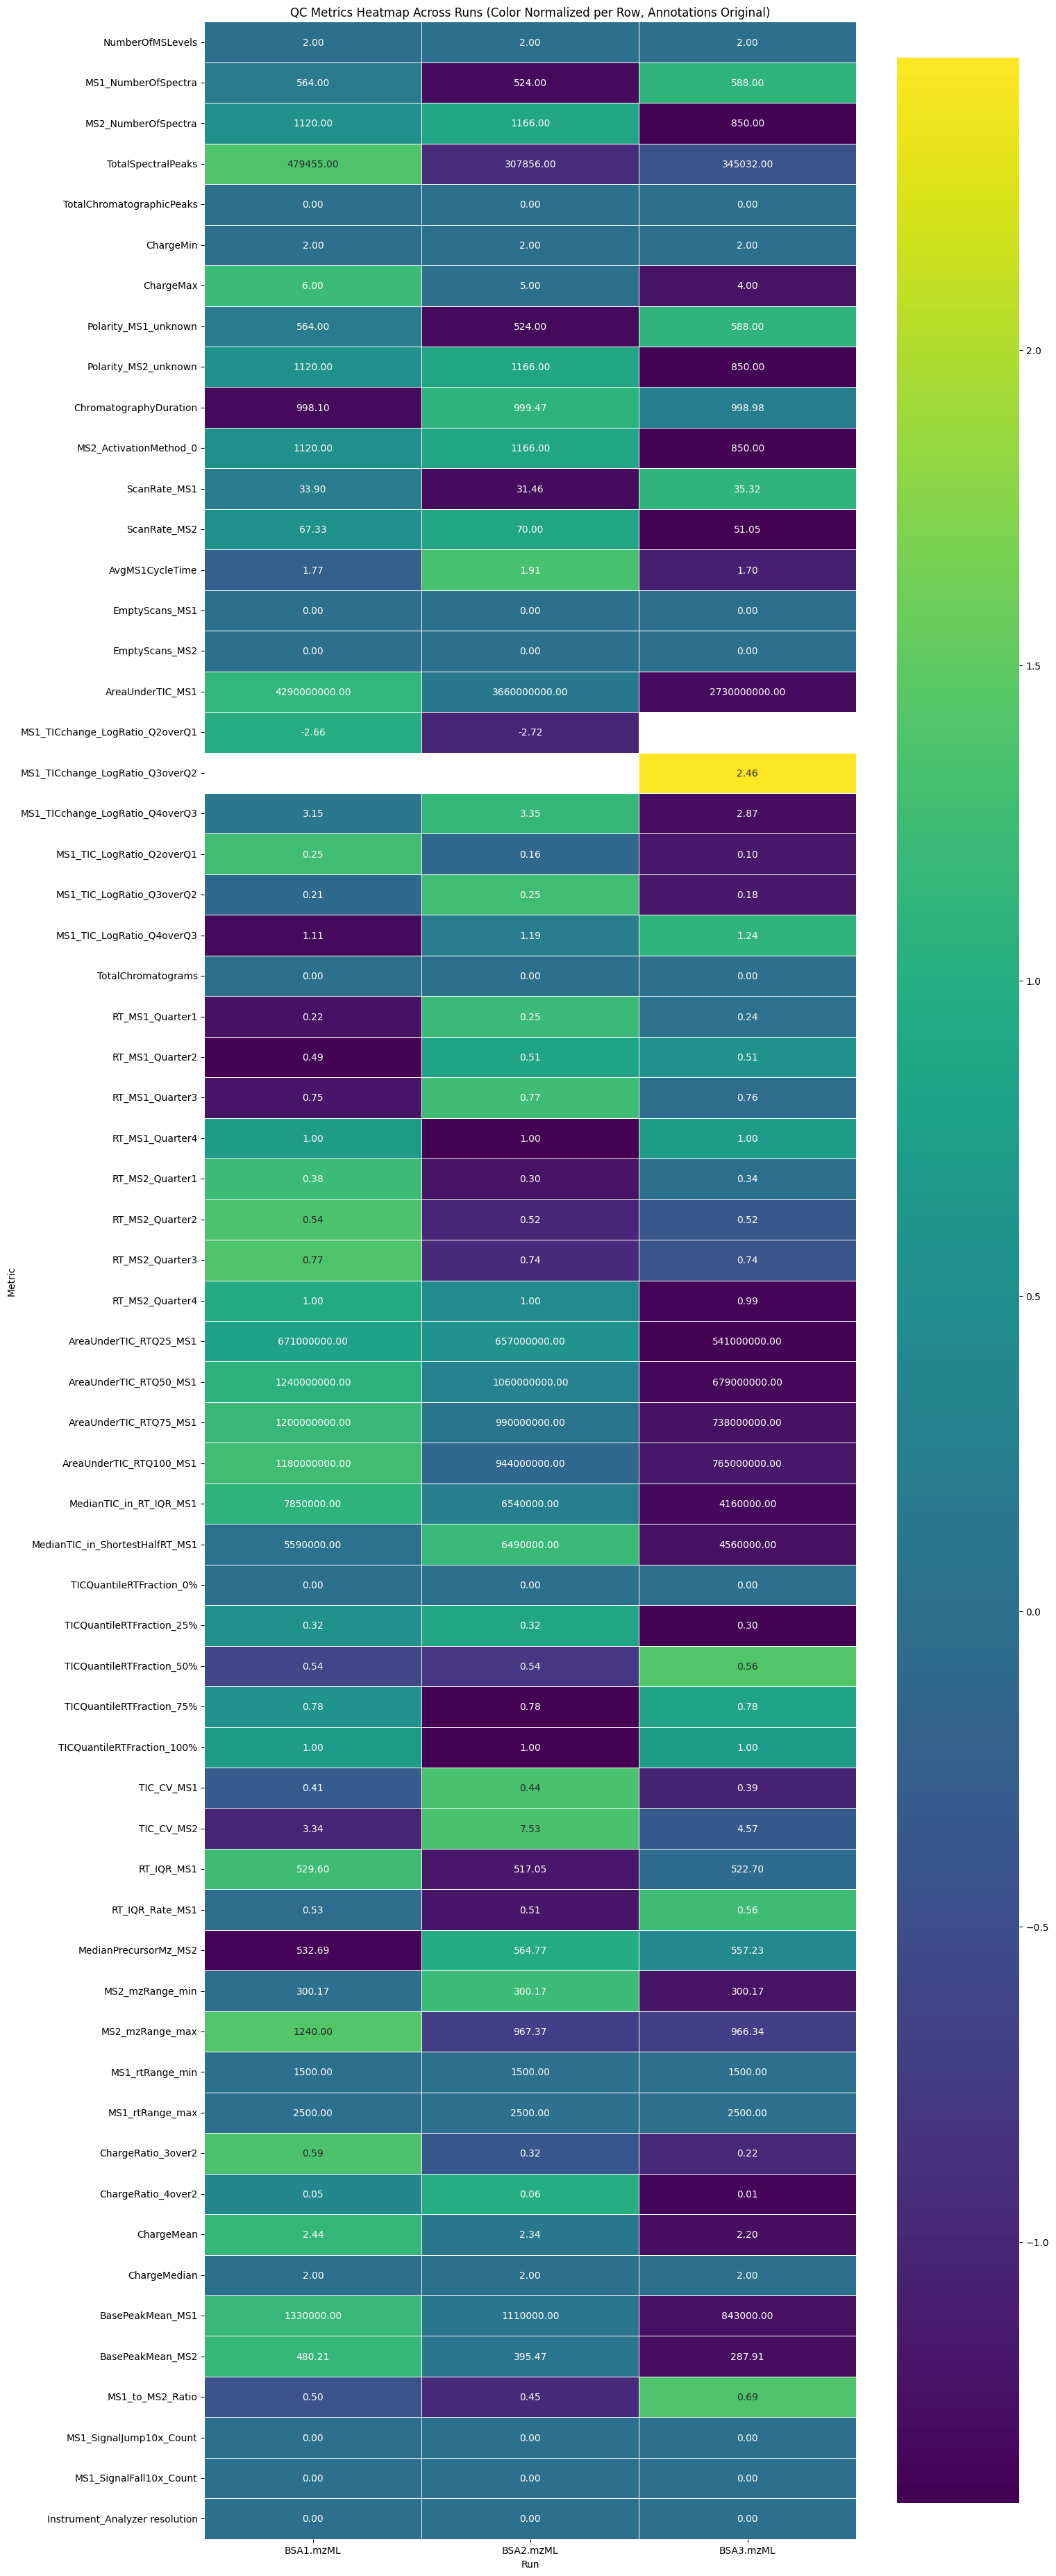

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Re-parse the mzQC JSON to get the structured data
run_labels, qc_metrics_dict, instrument_metrics_dict, lc_metrics_dict = parse_mzqc_metrics(json_str)

# Prepare data for heatmap
# Combine QC metrics, Instrument, and LC metadata for visualization
all_metrics_for_heatmap = {}

# Add QC metrics
for metric_name, metric_data in qc_metrics_dict.items():
    # Convert formatted values back to numeric where possible, use NaN otherwise
    values = []
    for val_str in metric_data['values']:
        try:
            values.append(float(val_str))
        except (ValueError, TypeError):
            values.append(np.nan)
    all_metrics_for_heatmap[metric_name] = values

# Add Instrument metadata (only numeric for heatmap)
for prop, values in instrument_metrics_dict.items():
     values_numeric = []
     for val_str in values:
         try:
             values_numeric.append(float(val_str))
         except (ValueError, TypeError):
             values_numeric.append(np.nan)
     if any(np.isfinite(values_numeric)): # Only include if at least one value is numeric
         all_metrics_for_heatmap[f"Instrument_{prop}"] = values_numeric


# Add LC metadata (only numeric for heatmap)
for prop, values in lc_metrics_dict.items():
    values_numeric = []
    for val_str in values:
        try:
            values_numeric.append(float(val_str))
        except (ValueError, TypeError):
            values_numeric.append(np.nan)
    if any(np.isfinite(values_numeric)): # Only include if at least one value is numeric
        all_metrics_for_heatmap[f"LC_{prop}"] = values_numeric


# Create a DataFrame
df_heatmap = pd.DataFrame(all_metrics_for_heatmap, index=run_labels).T # Transpose to have metrics as rows, runs as columns

# Handle potential non-numeric columns that might have slipped through or were intended
# Drop rows where all values are NaN (metrics not applicable or not numeric)
df_heatmap = df_heatmap.dropna(how='all')

# Store the original DataFrame for annotations
df_heatmap_original = df_heatmap.copy()

# Scale data for color intensity (row-wise)
from sklearn.preprocessing import StandardScaler

# Apply scaling row-wise
df_heatmap_scaled = df_heatmap.apply(lambda row: StandardScaler().fit_transform(row.values.reshape(-1, 1)).flatten() if row.notna().sum() > 1 else row, axis=1, result_type='broadcast')


# Generate the heatmap
# Use the scaled data for color and original data for annotations
plt.figure(figsize=(15, max(8, len(df_heatmap_scaled) * 0.6))) # Adjust figure size for annotations
sns.heatmap(df_heatmap_scaled.astype(float), annot=df_heatmap_original, fmt=".2f", cmap='viridis', linewidths=.5) # Use original data for annotations
plt.title('QC Metrics Heatmap Across Runs (Color Normalized per Row, Annotations Original)')
plt.xlabel('Run')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()